<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.7.4
IPython 7.8.0

numpy 1.16.5
scipy 1.4.1
pandas 0.25.1
matplotlib 3.1.1
statsmodels 0.10.1
sklearn 0.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores  : 12
interpreter: 64bit
Git hash   :


In [94]:
from __future__ import division, print_function
from tqdm import tqdm
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [4]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '.'

In [24]:
def write_answer_to_file(answer, file_address):
    with open(file_address, 'w') as out_f:
        out_f.write(str(answer))

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [5]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [6]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [8]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [9]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
knn = KNeighborsClassifier(100, n_jobs=-1)

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [31]:
accuracy = []
accuracy.append(cross_val_score(knn, X_train, y_train).mean())
knn.fit(X_train, y_train)
accuracy.append(accuracy_score(y_valid, knn.predict(X_valid)))
accuracy

[0.5593358012173123, 0.584024650391088]

In [32]:
write_answer_to_file(" ".join([f'{value:.3f}' for value in accuracy]), 
                     'Answers/answer4_1.txt')

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
forest = RandomForestClassifier(100, random_state=17, oob_score=True, n_jobs=-1)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_valid)
accuracy = [forest.oob_score_, accuracy_score(y_valid, y_pred)]
accuracy

[0.7172322698638488, 0.7312159279450107]

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [44]:
write_answer_to_file(" ".join([f'{value:.3f}' for value in accuracy]),
                     'Answers/answer4_2.txt')

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [46]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [47]:
logit = LogisticRegression(random_state=17, n_jobs=-1)

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [48]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(logit_c_values1, multi_class='multinomial', random_state=17)
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 20.2 s


LogisticRegressionCV(Cs=array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02]),
                     class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='multinomial', n_jobs=None,
                     penalty='l2', random_state=17, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [54]:
logit_mean_cv_scores1 = [np.mean([logit_grid_searcher1.scores_[31][j][i] for j in range(3)]) for i in range(10)]
logit_mean_cv_scores1

[0.3187351794641693,
 0.47266648070798384,
 0.5540521109478109,
 0.6501726857736219,
 0.7178429401583237,
 0.7504587865839746,
 0.7605166443762048,
 0.7574684179119063,
 0.7522866637587587,
 0.7404993991087463]

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [59]:
C_best = logit_c_values1[np.argmax(logit_mean_cv_scores1)]
C_best

1.0

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

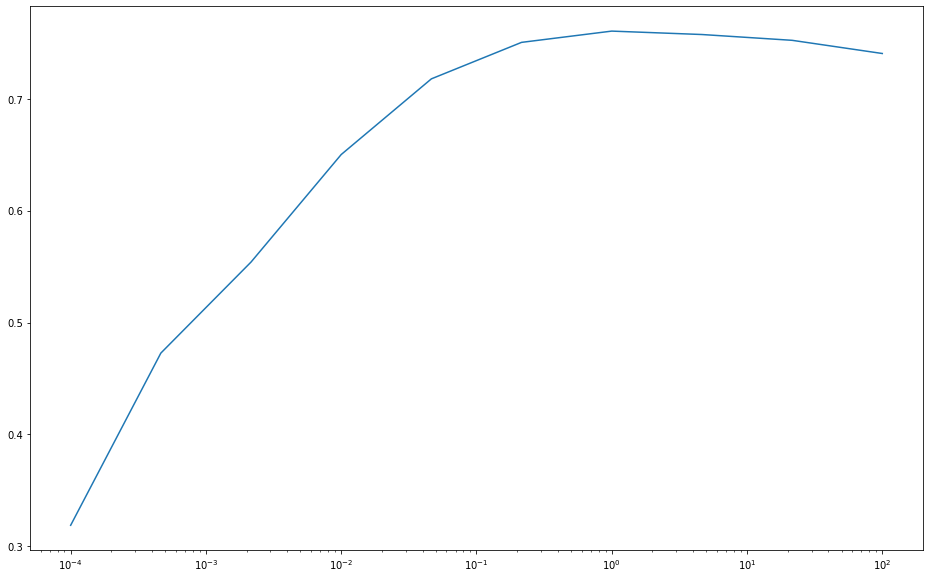

In [57]:
plt.figure(figsize=(16,10))
plt.plot(logit_c_values1, logit_mean_cv_scores1);
plt.xscale('log')

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [65]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(logit_c_values2, multi_class='multinomial', random_state=17)
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 51.3 s


LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='multinomial', n_jobs=None,
                     penalty='l2', random_state=17, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [67]:
logit_mean_cv_scores2 = [np.mean([logit_grid_searcher2.scores_[31][j][i] for j in range(3)]) for i in range(20)]
logit_mean_cv_scores2

[0.7368438622389794,
 0.7576715160366033,
 0.7608221724286656,
 0.7605165823524042,
 0.7602119822779582,
 0.7602122920004621,
 0.7608214603444555,
 0.7601107276304132,
 0.7587892787528556,
 0.758484307725103,
 0.7580780200260051,
 0.758078422387711,
 0.758180512770568,
 0.7576725370503188,
 0.7574694397186202,
 0.7568595903023173,
 0.7566560906089129,
 0.7564531169283167,
 0.756453054904516,
 0.7560463338318119]

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [68]:
C_best2 = logit_c_values2[np.argmax(logit_mean_cv_scores2)]
C_best2

0.8263157894736842

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

(0.755, 0.762)

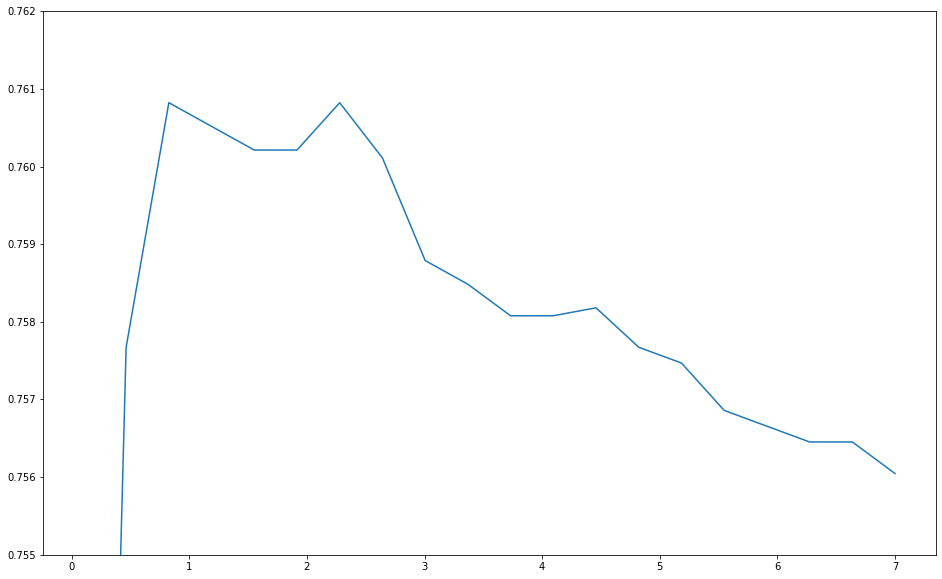

In [111]:
plt.figure(figsize=(16,10))
plt.plot(logit_c_values2, logit_mean_cv_scores2);
plt.ylim((0.755,0.762))
#plt.xscale('log')

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [74]:
logit_C_best = LogisticRegression(C=C_best2, random_state=17, n_jobs=-1)
logit_C_best.fit(X_train, y_train)
logit_cv_acc = accuracy_score(y_valid, logit_C_best.predict(X_valid))
logit_cv_acc

0.7788575491822707

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [75]:
accuracy = [max(logit_mean_cv_scores2), logit_cv_acc]
accuracy

[0.7608221724286656, 0.7788575491822707]

In [76]:
write_answer_to_file(" ".join([f'{value:.3f}' for value in accuracy]), 
                     'Answers/answer4_3.txt')

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [89]:
from sklearn.svm import LinearSVC

In [92]:
svm = LinearSVC(C=1, random_state=17)

In [93]:
accuracy = []
accuracy.append(cross_val_score(svm, X_train, y_train).mean())
svm.fit(X_train, y_train)
accuracy.append(accuracy_score(y_valid, svm.predict(X_valid)))
accuracy

[0.7540132242621972, 0.7769613652524295]

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [95]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, svm_params1)
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 45.6 s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LinearSVC(C=1, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [104]:
svm_grid_searcher1.cv_results_

{'mean_fit_time': array([0.04886889, 1.58209801, 1.57611752, 1.58443141, 1.58842421,
        1.58641911, 1.59107701, 1.5914108 , 1.5840954 , 1.58441472]),
 'std_fit_time': array([0.00162869, 0.0126277 , 0.01429989, 0.0205024 , 0.01372276,
        0.00610682, 0.01711991, 0.00862831, 0.0135645 , 0.00478257]),
 'mean_score_time': array([0.00099778, 0.00099802, 0.00066535, 0.00033251, 0.00099643,
        0.00066543, 0.0009977 , 0.00099921, 0.00099881, 0.00034205]),
 'std_score_time': array([0.00000000e+00, 1.94667955e-07, 4.70473799e-04, 4.70246438e-04,
        2.92865845e-06, 4.70527507e-04, 1.12391596e-07, 3.30935523e-06,
        3.51122571e-06, 4.83733429e-04]),
 'param_C': masked_array(data=[0.0001, 1111.1112, 2222.2223000000004,
                    3333.3334000000004, 4444.4445000000005,
                    5555.555600000001, 6666.666700000001,
                    7777.777800000001, 8888.8889, 10000.0],
              mask=[False, False, False, False, False, False, False, False,
      

In [97]:
svm_grid_searcher1.best_score_

0.692237350132087

In [96]:
svm_grid_searcher1.best_params_

{'C': 3333.3334000000004}

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

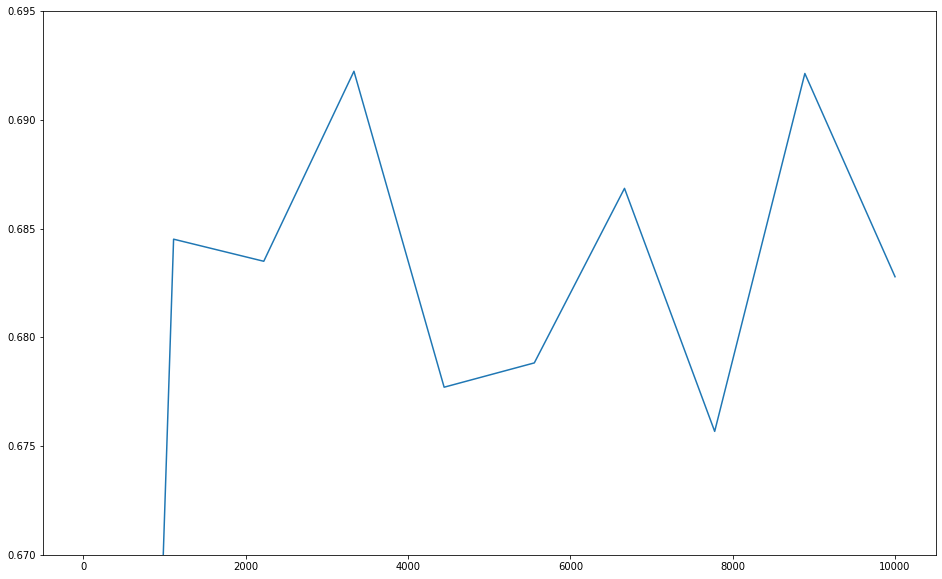

In [112]:
#plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)
plt.figure(figsize=(16,10))
plt.plot(svm_params1['C'], svm_grid_searcher1.cv_results_['mean_test_score'])
plt.ylim((0.67,0.695));
#plt.xscale('log')

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [114]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, svm_params2, return_train_score=True)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 1min 21s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LinearSVC(C=1, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'C': array([0.001     , 0.03544828, 0.06989655, 0.10434483, 0.1387931 ,
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [115]:
svm_grid_searcher2.best_score_

0.7661044503149766

In [116]:
svm_grid_searcher2.best_params_

{'C': 0.13879310344827586}

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

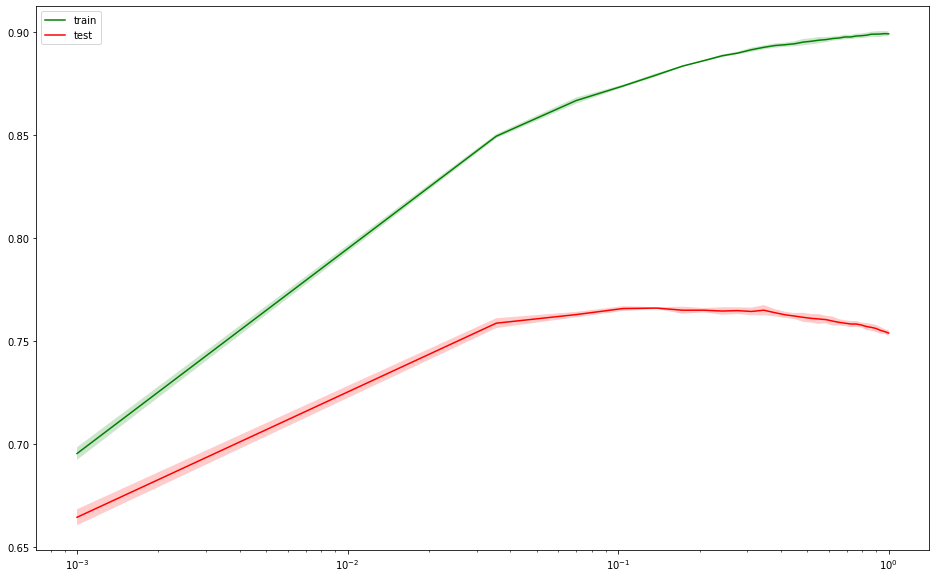

In [122]:
plt.figure(figsize=(16,10))
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)
# plt.plot(svm_params2['C'], svm_grid_searcher2.cv_results_['mean_test_score'])
plt.xscale('log')

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [123]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.best_estimator_.predict(X_valid))
svm_cv_acc

0.7817018250770325

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [124]:
accuracy = [svm_grid_searcher2.best_score_, svm_cv_acc]
write_answer_to_file(" ".join([f'{value:.3f}' for value in accuracy]), 
                     'Answers/answer4_4.txt')

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [147]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    
    with open(os.path.join(PATH_TO_DATA, 
              path_to_X_pickle), 'rb') as X_sparse_pkl:
        X_sparse = pickle.load(X_sparse_pkl)
    with open(os.path.join(PATH_TO_DATA, 
              path_to_y_pickle), 'rb') as y_pkl:
        y = pickle.load(y_pkl)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y,
                                                          test_size=test_size, random_state=random_state, stratify=y)
    accuracy_cv = cross_val_score(estimator, X_train, y_train).mean()
    estimator.fit(X_train, y_train)
    return [accuracy_cv, accuracy_score(y_valid, estimator.predict(X_valid))]

**Убедитесь, что функция работает.**

In [148]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
                 os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

[0.7661047482522512, 0.7817018250770325]

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [126]:
# !cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
# !cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
# !cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
# !cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [139]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in tqdm(itertools.product([10, 7, 5], [15, 10, 7, 5])):
    if window_size <= session_length:
        path_to_X_pkl = f'X_sparse_10users_s{session_length}_w{window_size}.pkl'
        path_to_y_pkl = f'y_10users_s{session_length}_w{window_size}.pkl'
        res = model_assessment(estimator, 
                               os.path.join(PATH_TO_DATA, path_to_X_pkl),
                               os.path.join(PATH_TO_DATA, path_to_y_pkl), skf, random_state=17, test_size=0.3)
        print(f'({session_length:02d}, {window_size:02d}): {res}')



0it [00:00, ?it/s]

(15, 10): (0.8220888995987848, 0.8307655842616734)




1it [00:02,  2.84s/it]

(10, 10): (0.7661047482522512, 0.7817018250770325)




2it [00:04,  2.39s/it]

(15, 07): (0.8487929231579824, 0.863447818151651)




5it [00:07,  2.01s/it]

(10, 07): (0.7980803031120156, 0.8324207731873237)




6it [00:09,  1.96s/it]

(07, 07): (0.7538408982244243, 0.7975775676124108)




7it [00:10,  1.71s/it]

(15, 05): (0.8673412989682229, 0.8691322901849218)




9it [00:15,  1.88s/it]

(10, 05): (0.8160265871722533, 0.8398530109056425)




10it [00:17,  2.06s/it]

(07, 05): (0.7700466073115632, 0.8027501185395922)




11it [00:19,  1.93s/it]

(05, 05): (0.7248788684867113, 0.7607871028923661)




12it [00:20,  1.69s/it]


Wall time: 20.2 s


**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [140]:
accuracy = [0.8673412989682229, 0.8691322901849218]
write_answer_to_file(" ".join([f'{value:.3f}' for value in accuracy]), 
                     'Answers/answer4_5.txt')

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [141]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = f'X_sparse_150users_s{session_length}_w{window_size}.pkl'
    path_to_y_pkl = f'y_150users_s{session_length}_w{window_size}.pkl'
    res = model_assessment(estimator, 
                           os.path.join(PATH_TO_DATA, path_to_X_pkl),
                           os.path.join(PATH_TO_DATA, path_to_y_pkl), skf, random_state=17, test_size=0.3)
    print(f'({session_length:02d}, {window_size:02d}): {res}')

TypeError: cannot unpack non-iterable int object

**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [149]:
%%time
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'),
                 os.path.join(PATH_TO_DATA, 'y_150users.pkl'), skf, random_state=17, test_size=0.3)

Wall time: 3min 53s


[0.46153234054364906, 0.48447915146207365]

In [150]:
accuracy = [0.46153234054364906, 0.48447915146207365]
write_answer_to_file(" ".join([f'{value:.3f}' for value in accuracy]), 
                     'Answers/answer4_6.txt')

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [151]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [152]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [187]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[logit_grid_searcher2.Cs_[10]], cv=skf, multi_class='ovr', random_state=17, n_jobs=-1)
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 4min 46s


LogisticRegressionCV(Cs=[3.7315789473684213], class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='ovr', n_jobs=-1,
                     penalty='l2', random_state=17, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [188]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user[user_id] = logit_cv_150users.scores_[user_id].mean()
    print(f'User {user_id}, CV score: {cv_scores_by_user[user_id]}')

User 6, CV score: 0.9960793346553416
User 13, CV score: 0.9963509534561782
User 15, CV score: 0.9952039715108505
User 16, CV score: 0.9920242525060452
User 28, CV score: 0.9904076911403137
User 31, CV score: 0.9942447330306018
User 33, CV score: 0.9935983376625162
User 39, CV score: 0.9860602484886853
User 46, CV score: 0.9979149213024526
User 49, CV score: 0.9951313515924252
User 50, CV score: 0.9942453108161621
User 53, CV score: 0.9936193152035542
User 65, CV score: 0.9969451635892863
User 66, CV score: 0.9946719907486496
User 82, CV score: 0.9962258117704225
User 85, CV score: 0.9963507844291443
User 89, CV score: 0.9904708257226696
User 92, CV score: 0.9944011192344542
User 100, CV score: 0.9945158525342351
User 102, CV score: 0.9914816590283939
User 103, CV score: 0.9810038304200542
User 105, CV score: 0.99694520088749
User 106, CV score: 0.9948082807971695
User 118, CV score: 0.9911066107455389
User 119, CV score: 0.9967263654154571
User 120, CV score: 0.9942448783314676
User 12

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [189]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = {}
for user_id in np.unique(y_train_150):
    acc_diff_vs_constant[user_id] = cv_scores_by_user[user_id]-(sum(class_distr)-class_distr[user_id])/(float)(sum(class_distr))

In [190]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()
num_better_than_default

121

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [191]:
write_answer_to_file(f'{(num_better_than_default/150.):.3f}', 
                     'Answers/answer4_7.txt')

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [ ]:
y_binary_128 = ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [ ]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

In [1]:
# sleep(3)
# from IPython.lib.display import Audio
# import numpy as np

# framerate = 4410
# play_time_seconds = 3

# t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
# audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
# Audio(audio_data, rate=framerate, autoplay=True)

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.